In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 29.6 MB/s eta 0:00:00


In [2]:
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers==0.0.16rc425

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 767.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 1.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have t

# Manually working with the different components

In [3]:
import torch
from torch import autocast
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import AutoencoderKL#KL-loss
from diffusers import LMSDiscreteScheduler#Schedulers help in fine-tuning the training dynamics
from diffusers import UNet2DConditionModel
from diffusers.schedulers.scheduling_ddim import DDIMScheduler #denoising

from tqdm import tqdm #progressbar
from PIL import Image

In [15]:
class ImageDiffusionModel:

    def __init__(self, vae, tokenizer, text_encoder, unet,
                 scheduler_LMS, scheduler_DDIM):
        self.vae = vae#auto encoder
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler_LMS = scheduler_LMS
        self.scheduler_DDIM = scheduler_DDIM
        self.device = 'cuda'

    def get_text_embeds(self, text):
        # tokenize the text
        text_input = self.tokenizer(text,
                                    padding='max_length',
                                    max_length=tokenizer.model_max_length,
                                    truncation=True,
                                    return_tensors='pt')
        # embed the text
        with torch.no_grad():
            text_embeds = self.text_encoder(text_input.input_ids.to(self.device))[0]

        return text_embeds

    def get_prompt_embeds(self, prompt):
        # get conditional prompt embeddings
        cond_embeds = self.get_text_embeds(prompt)
        # get unconditional prompt embeddings
        uncond_embeds = self.get_text_embeds([''] * len(prompt))
        # concatenate the above 2 embeds
        prompt_embeds = torch.cat([uncond_embeds, cond_embeds])
        return prompt_embeds

    def get_img_latents(self,
                        text_embeds,
                        height=512, width=512,
                        num_inference_steps=50,
                        guidance_scale=7.5,
                        img_latents=None):
        # if no image latent is passed, start reverse diffusion with random noise
        if img_latents is None:
            img_latents = torch.randn((text_embeds.shape[0] // 2, self.unet.in_channels,\
                                       height // 8, width // 8)).to(self.device)
        # set the number of inference steps for the scheduler
        self.scheduler_LMS.set_timesteps(num_inference_steps)
        # scale the latent embeds
        img_latents = img_latents * self.scheduler_LMS.sigmas[0]
        # using autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_LMS.timesteps)):
                # doing a single forward pass for both the conditional and unconditional latents
                latent_model_input = torch.cat([img_latents] * 2)
                sigma = self.scheduler_LMS.sigmas[i]
                latent_model_input = latent_model_input / ((sigma ** 2 + 1) ** 0.5)

                # predicting noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']

                # separating predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                # performing guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # removing the noise from the current sample i.e. go from x_t to x_{t-1}
                img_latents = self.scheduler_LMS.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents


    def decode_img_latents(self, img_latents):
        img_latents = img_latents / 0.18215
        with torch.no_grad():
            imgs = self.vae.decode(img_latents)["sample"]
        # load image in the CPU
        imgs = imgs.detach().cpu()
        return imgs

    def transform_imgs(self, imgs):
        # transform images from the range [-1, 1] to [0, 1]
        imgs = (imgs / 2 + 0.5).clamp(0, 1)
        # permute the channels and convert to numpy arrays
        imgs = imgs.permute(0, 2, 3, 1).numpy()
        # scale images to the range [0, 255] and convert to int
        imgs = (imgs * 255).round().astype('uint8')
        # convert to PIL Image objects
        imgs = [Image.fromarray(img) for img in imgs]
        return imgs

    def prompt_to_img(self,
                      prompts,
                      height=512, width=512,
                      num_inference_steps=50,
                      guidance_scale=7.5,
                      img_latents=None):

        # convert prompt to a list
        if isinstance(prompts, str):
            prompts = [prompts]

        # get prompt embeddings
        text_embeds = self.get_prompt_embeds(prompts)

        # get image embeddings
        img_latents = self.get_img_latents(text_embeds,
                                      height, width,
                                      num_inference_steps,
                                      guidance_scale,
                                      img_latents)
        # decode the image embeddings
        imgs = self.decode_img_latents(img_latents)
        # convert decoded image to suitable PIL Image format
        imgs = self.transform_imgs(imgs)

        return imgs

    def encode_img_latents(self, imgs):
        if not isinstance(imgs, list):
            imgs = [imgs]

        imgs = np.stack([np.array(img) for img in imgs], axis=0)
        # scale images to the range [-1, 1]
        imgs = 2 * ((imgs / 255.0) - 0.5)
        imgs = torch.from_numpy(imgs).float().permute(0, 3, 1, 2)

        # encode images
        img_latents_dist = self.vae.encode(imgs.to(self.device))
        # img_latents = img_latents_dist.sample()
        img_latents = img_latents_dist["latent_dist"].mean.clone()
        # scale images
        img_latents *= 0.18215

        return img_latents

    def get_img_latents_similar(self,
                                img_latents,
                                text_embeds,
                                height=512, width=512,
                                num_inference_steps=50,
                                guidance_scale=7.5,
                                start_step=10):

        # set the number of inference steps for the scheduler
        self.scheduler_DDIM.set_timesteps(num_inference_steps)

        if start_step > 0:
            start_timestep = self.scheduler_DDIM.timesteps[start_step]
            start_timesteps = start_timestep.repeat(img_latents.shape[0]).long()

            noise = torch.randn_like(img_latents)
            img_latents = scheduler_DDIM.add_noise(img_latents, noise, start_timesteps)

        # use autocast for automatic mixed precision (AMP) inference
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_DDIM.timesteps[start_step:])):
                # do a single forward pass for both the conditional and unconditional latents
                latent_model_input = torch.cat([img_latents] * 2)

                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeds)['sample']

                # separate predictions for unconditional and conditional outputs
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                # perform guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # remove the noise from the current sample i.e. go from x_t to x_{t-1}
                img_latents = self.scheduler_DDIM.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents

    def similar_imgs(self,
                     img,
                     prompt,
                     height=512, width=512,
                     num_inference_steps=50,
                     guidance_scale=7.5,
                     start_step=10):

        # get image latents
        img_latents = self.encode_img_latents(img)

        if isinstance(prompt, str):
            prompt = [prompt]

        text_embeds = self.get_prompt_embeds(prompt)

        img_latents = self.get_img_latents_similar(img_latents=img_latents,
                                                   text_embeds=text_embeds,
                                                height=height, width=width,
                                                num_inference_steps=num_inference_steps,
                                                guidance_scale=guidance_scale,
                                                start_step=start_step)

        imgs = self.decode_img_latents(img_latents)
        imgs = self.transform_imgs(imgs)
        # Clear the CUDA cache
        torch.cuda.empty_cache()

        return imgs


In [ ]:
device = 'cuda'

model_name = "CompVis/stable-diffusion-v1-4"
# Load autoencoder
vae = AutoencoderKL.from_pretrained(model_name,
                                    subfolder='vae').to(device)

# Load tokenizer and the text encoder
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device)

# Load UNet model
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder='unet').to(device)

# Load scheduler
scheduler_LMS = LMSDiscreteScheduler(beta_start=0.00085,
                                 beta_end=0.012,
                                 beta_schedule='scaled_linear',
                                 num_train_timesteps=1000)

scheduler_DDIM = DDIMScheduler(beta_start=0.00085,
                               beta_end=0.012,
                               beta_schedule='scaled_linear',
                               num_train_timesteps=1000)

In [17]:
model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompts = ["Beautiful, abstract art of a human mind, 3D, highly detailed, 8K, aesthetic",
           "astronaut playing a violin in moon, real life"]

imgs = model.prompt_to_img(prompts)

<ipython-input-15-5cf5fbceef8c>:43: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  img_latents = torch.randn((text_embeds.shape[0] // 2, self.unet.in_channels,\
50it [00:25,  1.94it/s]


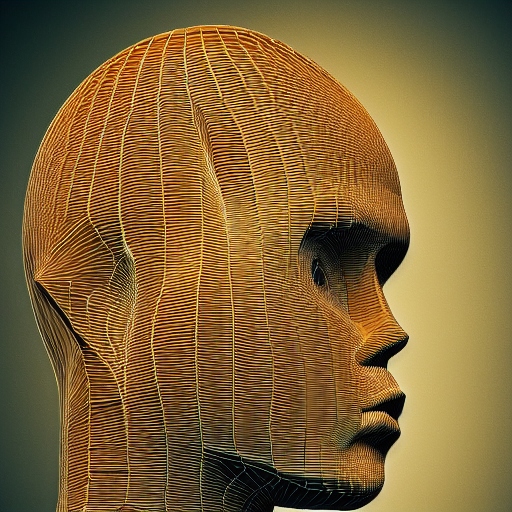

In [18]:
imgs[0]

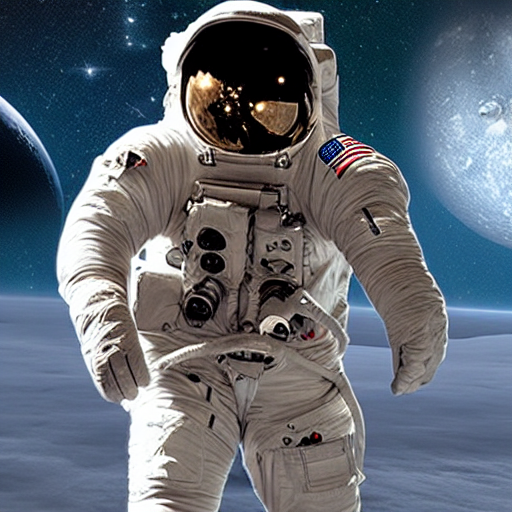

In [19]:
imgs[1]

In [20]:
# saving the image
imgs[0].save("mind.png")

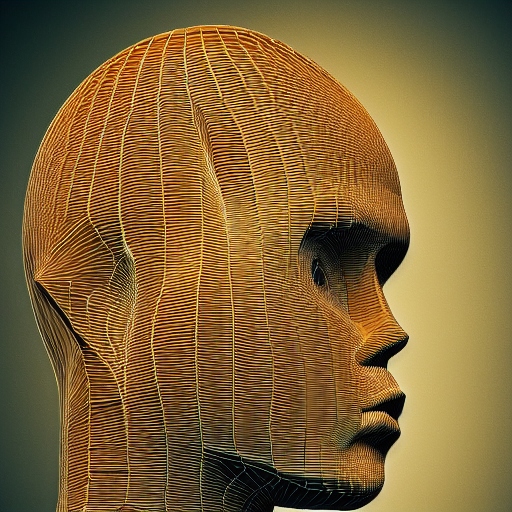

In [21]:
# loading the image again
original_img = Image.open("mind.png")
original_img

In [22]:
import torch
import gc

# Clear the CUDA cache
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [23]:
!nvidia-smi

Thu Dec  7 09:14:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    38W /  70W |   5547MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

20it [00:05,  3.96it/s]


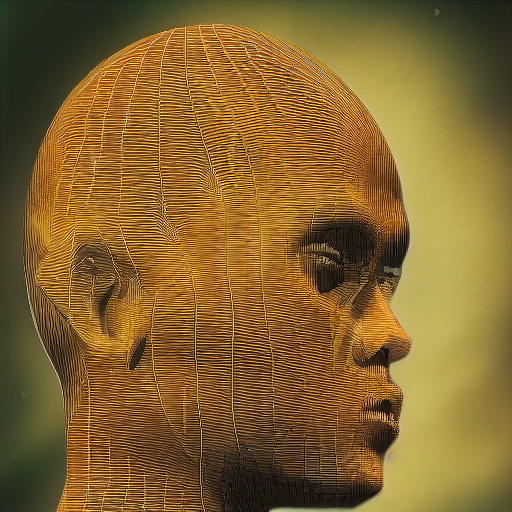

In [25]:
model = ImageDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

imgs = model.similar_imgs(original_img, prompt, num_inference_steps=50, start_step=30)
imgs[0]